<a href="https://colab.research.google.com/github/Aryanshukla-09/Module-9-lab-3-CN-NETWORK/blob/main/Module_9_lab_3_CN_NETWORK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Module 9: Convolutional Neural Networks

Lab 3

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Importing some pytorch packages
import torch
from torch.nn import Conv2d

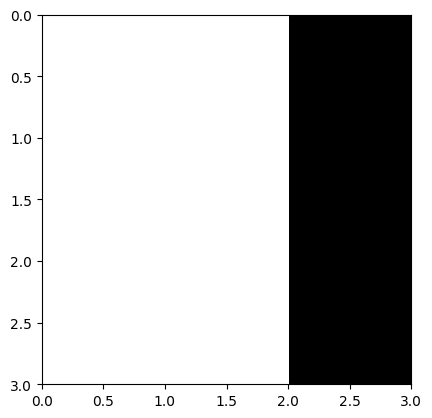

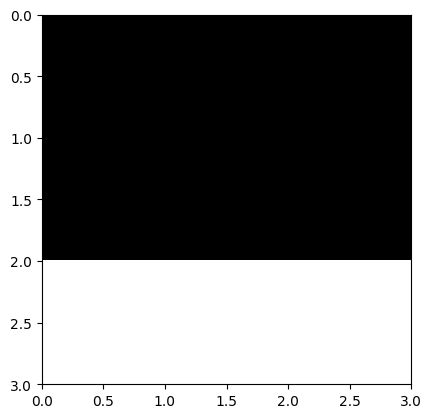

In [3]:
# 2D 3x3 binary image with vertical edge
image1 = np.array([[1,1,0], [1,1,0], [1,1,0]])

# 2D 3x3 binary image with horizontal edge
image2 = np.array([[0,0,0], [0,0,0], [1,1,1]])

# On plotting the images
plt.imshow(image1, cmap='gray', extent=[0, 3, 3, 0])
plt.show()
plt.imshow(image2, cmap='gray', extent=[0, 3, 3, 0])
plt.show()

In [4]:
# Vertical Line filter
filter = np.array([[1,0,-1],
                   [1,0,-1],
                   [1,0,-1]])

# Applying filter to first image
output = np.sum(np.multiply(image1, filter))
print('Output from first image: ', output)

# Applying filter to second image
output = np.sum(np.multiply(image2, filter))
print('Output from second image: ', output)

Output from first image:  3
Output from second image:  0


In [5]:
# Horizontal edge filter
filter = np.array([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]])

output = np.sum(np.multiply(image1, filter))
print('Output from first image: ', output)

output = np.sum(np.multiply(image2, filter))
print('Output from second image: ', output)

Output from first image:  0
Output from second image:  3


In [6]:
def apply_conv(image, kernel, padding=0, stride=1):

  #--------IMAGE PREPROCESSING-------
  image = torch.from_numpy(image)
  # Pytorch requires input to convolution in (N,C,H,W), where N = batch size and C=#channels in input
  input = image.view((1,1,image.shape[0], image.shape[1]))

  # --------------KERNEL-------------
  kernel = torch.from_numpy(kernel.astype(np.float32))

  # Pytorch requires kernel of shape (N,C,H,W), where N = batch size and C=#channels in input
  kernel = kernel.view((1,1,kernel.shape[0], kernel.shape[1]))

  # ---------CONVOLUTION LAYER from Pytorch--------
  conv = Conv2d(in_channels=1, out_channels=1, kernel_size=kernel.shape, padding=padding, stride=stride)

  # Set the kernel weights in the convolution layer
  conv.weight = torch.nn.Parameter(kernel)

  # ---------APPLY CONVOLUTION--------
  output = conv(input.float())
  output_img = output.data.numpy()  # Tensor to back in numpy
  output_img = output_img.reshape((-1, output_img.shape[-1])) # Reshape to 2D image

  return output_img

In [7]:
# Our original lotus image
image = cv2.imread('/content/grid1 (1).jpg', 0)

filter = np.array([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]])

out1 = apply_conv(image, filter, padding=0, stride=1)

filter = np.array([[1,0,-1],
                   [1,0,-1],
                   [1,0,-1]])

out2 = apply_conv(image, filter, padding=0, stride=1)

TypeError: expected np.ndarray (got NoneType)

Learning to train a CNN network

In [9]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [10]:
#  Images returned from torchvision dataset classes is in range [0,1]
# We transform them to tensors and normalize them to range [-1,1] using 'Normalize' transform

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Classes in CIFAR10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 95517032.71it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [11]:
print('Training data shape : ', trainset.data.shape, len(trainset.targets))
print('Testing data shape : ', testset.data.shape, len(testset.targets))

# Find the unique numbers from the train labels
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Training data shape :  (50000, 32, 32, 3) 50000
Testing data shape :  (10000, 32, 32, 3) 10000
Total number of outputs :  10
Output classes :  ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [12]:
def train(num_epochs, model, train_loader, loss_func, optimizer):

  # Training mode
  model.train()

  train_losses = []
  train_acc = []

  # Train the model
  for epoch in range(num_epochs):
    running_loss = 0
    running_acc = 0
    for i, (images, labels) in enumerate(train_loader):

      # clear gradients for this training step
      optimizer.zero_grad()

      # Forward pass
      output = model(images)

      # Calculate loss
      loss = loss_func(output, labels)

      # Backpropagation, compute gradients
      loss.backward()

      # Apply gradients
      optimizer.step()

      # Running loss
      running_loss += loss.item()

      # indices of max probabilities
      _, preds = torch.max(output, dim=1)

      # Calculate number of correct predictions
      correct = (preds.float() == labels).sum()
      running_acc += correct

      # Average loss and acc values
      epoch_loss = running_loss / len(train_loader.dataset)
      epoch_acc = running_acc / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    print ('Epoch {}/{}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc*100))

  return train_losses, train_acc

In [13]:
def test_model(model, testloader):
  correct = 0
  total = 0
  # Deactivate autograd engine (don't compute grads since we're not training)
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network
        outputs = model(images)
        # The class with the highest value is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))

In [14]:
# CNN with 2 CONV layers and 3 FC layers
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 128)
        # output layer 10 classes
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [16]:
# Cross Entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()

In [17]:
# SGD optimizer with momentum
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

In [18]:
num_epochs = 5  # iterations
train_losses, train_acc = train(num_epochs, model, trainloader, criterion, optimizer)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/5, Loss: 0.0129, Accuracy: 39.0440
Epoch 2/5, Loss: 0.0094, Accuracy: 57.4000
Epoch 3/5, Loss: 0.0080, Accuracy: 64.0200
Epoch 4/5, Loss: 0.0068, Accuracy: 69.3820
Epoch 5/5, Loss: 0.0060, Accuracy: 73.1980


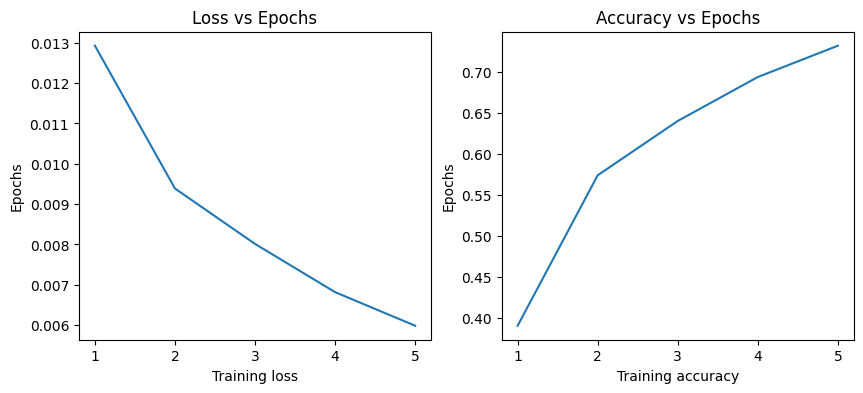

In [19]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2, 1)
ax.plot(np.arange(1,len(train_losses)+1),train_losses)
plt.xlabel('Training loss')
plt.ylabel('Epochs')
ax.set_title('Loss vs Epochs')
ax = fig.add_subplot(1,2, 2)
ax.plot(np.arange(1,len(train_acc)+1),train_acc)
plt.xlabel('Training accuracy')
plt.ylabel('Epochs')
ax.set_title('Accuracy vs Epochs')
plt.show()

In [20]:
# Accuracy on test data after training
test_model(model, testloader)

Accuracy of the network: 66 %


Questions

1) List some reasons why we should prefer CNN over ANN for image classification?

2) Try improving the CNN performance further by tuning the hyperparameters(epochs, optimizer, LR etc). Report the improved test accuracy.

3) What happens if you reduce the number of convolution layers to only 1?

4) Why didn't we use the Softmax activation in the last layer of CNN?

Answer Q1)

CNNs (Convolutional Neural Networks) are typically preferred over ANNs (Artificial Neural Networks) for image classification due to several reasons:

1)Hierarchical Feature Learning: CNNs are designed to automatically and adaptively learn spatial hierarchies of features directly from the image data. They use convolutional layers to extract low-level features like edges and textures, gradually combining them to form higher-level features, which is crucial for understanding visual content.

2)Parameter Sharing: CNNs utilize parameter sharing in convolutional layers, where a single set of weights is used across different spatial locations. This reduces the number of parameters in the model significantly, making it more efficient and capable of handling large image datasets.

3)Translation Invariance: CNNs inherently possess translation invariance due to the shared weights in convolutional layers. This means they can recognize patterns regardless of their position in the image, which is essential for tasks like object recognition.

4)Local Connectivity: CNNs exploit the local connectivity pattern present in images. Neurons in one layer are only connected to a small region of the input volume, enabling them to capture local patterns effectively.

5)Pooling Layers: CNNs often include pooling layers that progressively reduce the spatial dimensions of the representation, while maintaining the important information. Pooling helps in achieving spatial invariance and reducing computational complexity.

6)Pre-trained Models: CNNs can benefit from pre-trained models on large datasets like ImageNet, which have learned a rich set of hierarchical features. Fine-tuning these pre-trained models for specific tasks often leads to better performance with less training data.

Answer Q2)

Improving CNN performance can involve tuning various hyperparameters such as the number of epochs, optimizer, learning rate, etc. To report the improved test accuracy, you would typically perform a grid search or random search over these hyperparameters, training and evaluating the model on a validation set, and then selecting the best performing configuration.

For instance, you could try increasing the number of epochs to allow the model more time to converge, experiment with different optimizers such as Adam, RMSprop, or SGD with momentum, and adjust the learning rate accordingly. Additionally, you might explore techniques like data augmentation or adjusting the architecture of the CNN (e.g., adding more convolutional layers, increasing the depth of the network) to further enhance performance.

Once you've identified the best hyperparameters, you would train the CNN on the entire training set using those hyperparameters and evaluate its performance on a separate test set to report the improved test accuracy.

Answer Q3)

Reducing the number of convolutional layers to only 1 in a CNN can significantly limit the model's ability to learn hierarchical features from the input images. Convolutional layers are essential for capturing different levels of abstraction in visual data, starting from simple features like edges and textures to more complex patterns representing objects or structures.

With just one convolutional layer, the model would have a very limited capacity to extract meaningful features from the input images, which could result in poor performance, especially on tasks like image classification where understanding hierarchical features is crucial.

In essence, reducing the number of convolutional layers to 1 would severely restrict the expressive power of the CNN, making it less effective for tasks requiring sophisticated feature extraction and representation.

Answer Q4)

Softmax activation is typically used in the last layer of a neural network for multi-class classification tasks, including image classification. However, in the case of CNNs, it's common to omit the softmax activation in the last layer, especially when using frameworks like TensorFlow or PyTorch.

The reason for this omission is that the softmax activation function is usually incorporated into the loss function directly, such as softmax cross-entropy loss. These frameworks provide specialized loss functions that include softmax computation along with the calculation of the cross-entropy loss, simplifying the model implementation.

Therefore, while you don't explicitly see a softmax activation layer in the last layer of a CNN, it's implicitly included through the choice of loss function during training. This approach improves computational efficiency and numerical stability during training, especially for deep neural networks like CNNs.